In [1]:
import sys
import os

sys.path.append(os.path.abspath('..'))

In [2]:
from utils import get_cuda_info

get_cuda_info()

PyTorch version: 2.5.1+cu118
**********
_CUDA version: 
CUDA version:
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Wed_Oct_30_01:18:48_Pacific_Daylight_Time_2024
Cuda compilation tools, release 12.6, V12.6.85
Build cuda_12.6.r12.6/compiler.35059454_0

**********
CUDNN version: 90100
Available GPU devices: 1
Device Name: NVIDIA GeForce RTX 4070 Ti SUPER


## Wybór optymalnych punktów charakterystycznych

In [3]:
import numpy as np

OPTIMIZED_LANDMARK_INDEXES = np.load(os.path.join('..', '..', 'data', 'landmarks', 'top_100_important_landmarks_emotions.npy'))
PRESELECTED_LANDMARK_INDEXES = np.load(os.path.join('..', '..', 'data', 'landmarks', 'manualy_selected_points.npy'))

LANDMARK_INDEXES = np.union1d(OPTIMIZED_LANDMARK_INDEXES, PRESELECTED_LANDMARK_INDEXES)
# np.save(os.path.join('..', '..', 'data', 'landmarks', 'combined_selected_points_emotions.npy'), LANDMARK_INDEXES)

### Wizualizacja wybranych punktów

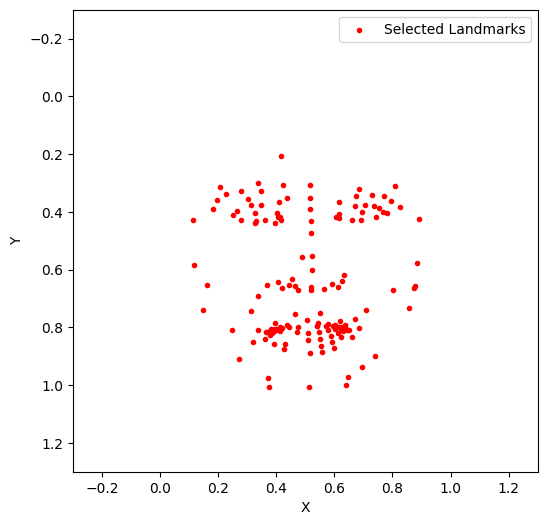

In [4]:
from utils import visualize_landmarks

visualize_landmarks(LANDMARK_INDEXES)

### Zdobycie danych

In [5]:
from utils import load_data, get_selected_landmarks

all_data, all_labels = load_data('ravdess')
all_data = get_selected_landmarks(all_data, LANDMARK_INDEXES)

## Preprocessing danych

In [6]:
from utils import preprocess_data

X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(all_data, all_labels)

In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(all_data, all_labels)

In [8]:
print(X_train.shape)
print(y_train.shape)

torch.Size([2012, 157, 154, 2])
torch.Size([2012, 8])


# MODEL TORCH

## Zbudowanie modelu ekstrakcji cech

In [9]:
import torch.nn as nn
import torch.nn.functional as F

In [10]:
class EmotionClassifier(nn.Module):
    def __init__(self, number_landmarks=LANDMARK_INDEXES.size):
        super(EmotionClassifier, self).__init__()

        self.number_landmarks = number_landmarks
        
        # Spatial feature extraction using Conv1D
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)
        
        # Calculate the number of features after Conv1D and pooling
        # Conv1D output: (batch_size * frames, 32, number_landmarks)
        # Pool1D output: (batch_size * frames, 32, number_landmarks // 2)
        self.flattened_features = 32 * (number_landmarks // 2)
        
        # LSTM layers for temporal feature extraction
        self.lstm1 = nn.LSTM(input_size=self.flattened_features, hidden_size=128, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(input_size=128 * 2, hidden_size=64, batch_first=True)
        
        # Fully connected classification layer
        self.fc = nn.Linear(64, 8)  # 8 emotion classes

    def forward(self, x):
        # x shape: (batch_size, frames, number_landmarks, 2)
        batch_size, frames, landmarks, coordinates = x.shape
        
        # Reshape for Conv1D: (batch_size * frames, coordinates, landmarks)
        x = x.view(-1, landmarks, coordinates).permute(0, 2, 1)  # Shape: (batch_size * frames, 2, number_landmarks)
        
        # Spatial feature extraction
        x = F.relu(self.conv1(x))  # Shape: (batch_size * frames, 32, number_landmarks)
        x = self.pool1(x)          # Shape: (batch_size * frames, 32, number_landmarks // 2)
        
        # Flatten spatial features
        x = x.view(batch_size, frames, -1)  # Shape: (batch_size, frames, 32 * (number_landmarks // 2))
        
        # Temporal feature extraction
        x, _ = self.lstm1(x)  # Shape: (batch_size, frames, 128 * 2)
        x, _ = self.lstm2(x)  # Shape: (batch_size, frames, 64)
        
        # Classification
        x = self.fc(x[:, -1, :])  # Take the last timestep's output; Shape: (batch_size, 8)
        return x


In [11]:
from torch.optim import Adam

model = EmotionClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=1e-4)

## Trening modelu

In [12]:
from torch.utils.tensorboard import SummaryWriter

RUNS_FOLDER_PATH = os.path.abspath('runs')
writer_path = os.path.join('runs', 'torch_lstm', 'emotion_classifier_selected_and_optimized_landmarks')
writer = SummaryWriter(writer_path)

In [14]:
from utils.model_functions import train_torch_model_multiclass

train_torch_model_multiclass(model, criterion, optimizer, X_train, y_train, X_val, y_val, writer=writer)


                                          EPOCH STATISTICS                                          
Epoch       : 1
----------------------------------------------------------------------------------------------------
                     TRAINING                                         VALIDATION                    
----------------------------------------------------------------------------------------------------
Loss        : 130.316232                                    Loss        : 28.878199
Accuracy    : 0.1233                                    Accuracy    : 0.1276
Precision   : 0.0613                                    Precision   : 0.0160
Recall      : 0.1134                                    Recall      : 0.1250
F1 Score    : 0.0773                                    F1 Score    : 0.0283


                                          EPOCH STATISTICS                                          
Epoch       : 2
--------------------------------------------------------------------

## Ewaluacja modelu

In [16]:
from utils.model_functions import eval_torch_model_multiclass

eval_torch_model_multiclass(model, criterion, X_test, y_test)


                                          EPOCH STATISTICS                                          
Epoch       : 1
----------------------------------------------------------------------------------------------------
                                             VALIDATION                                             
----------------------------------------------------------------------------------------------------
Loss        : 15.731166
Accuracy    : 0.5417
Precision   : 0.5207
Recall      : 0.5279
F1 Score    : 0.5153

